<a href="https://colab.research.google.com/github/teoad95/Sport-analytics/blob/main/Football_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Football analytics using AI techniques</h1>
<p> </p>

In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
import time
from PIL import Image

In [3]:
%matplotlib inline

In [2]:
pip install pytube

In [45]:
pip install torch==1.8.1

     |████████████████████████████████| 804.1MB 16kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


In [11]:
pip install torchvision==0.9.1

     |████████████████████████████████| 17.4MB 204kB/s 
  Using cached https://files.pythonhosted.org/packages/56/74/6fc9dee50f7c93d6b7d9644554bdc9692f3023fa5d1de779666e6bf8ae76/torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
  Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


##1 Generate dataset
For dataset generation (frame pictures) we created a function which given a youtube link, downloads the video and split it into frames every 0.5 sec.

In [4]:
from util_funs import get_frames_from_youtube_video
get_frames_from_youtube_video('https://www.youtube.com/watch?v=TeTQO5DgOXI')

Downloaded /content/Videos/Highlights Real Madrid vs FC Barcelona (2-1).mp4, in location Videos correctly!


In [7]:
image_location = '/content/Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame53.jpg'

##2 Detect players
For this task we used the pre-trained YOLO neural network.

In [5]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...
  Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2021-7-6 torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [8]:
img = cv2.imread(image_location, cv2.IMREAD_COLOR)

In [9]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

RuntimeError: ignored

In [33]:
img = Image.open(image_location)

AttributeError: ignored

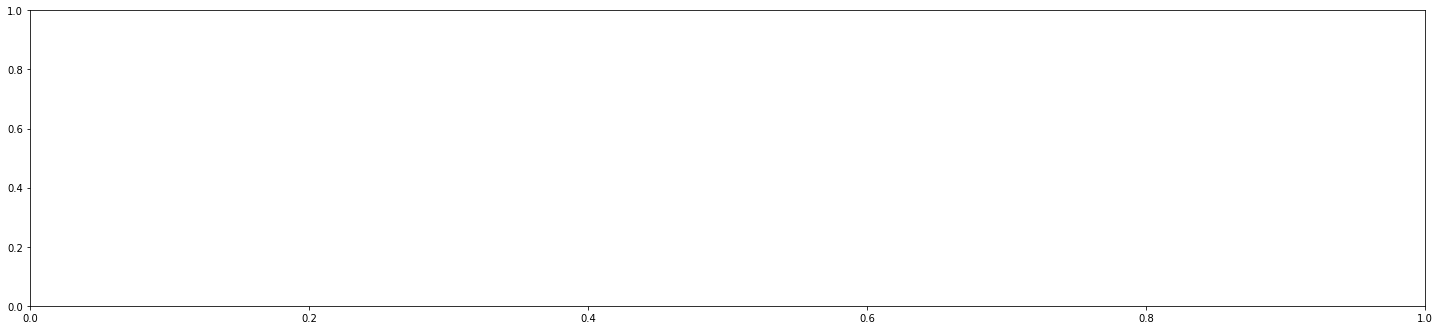

In [40]:
from PIL import Image
from util_funs import sliding_window
import math


fig = plt.figure(figsize=(25, 25))

#img = Image.open(image_location)
img_width, img_height = img.size
step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
 
    # inference
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plt.title(box)
    plt.imshow(cv2_img_bb)
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df)

                
                
print("--- %.2f seconds ---" % (time.time() - start_time))